# **Taxi 🚕 Data** 📊: What is the most important factor in determining the amount sold by the taxi industry?

## Loading CSV file. 
First things first. We need to Lead the raw data. 

In [81]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import scipy as sp



# Define the ZIP file name
zip_file_name = 'Yellow_Taxi_Assignment.csv.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_file:
    # Assuming there is only one CSV file in the ZIP archive
    csv_file_name = zip_file.namelist()[0]
    zip_file.extract(csv_file_name)

# Define the date columns that you want to parse as datetime objects
date_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

# Read the extracted CSV file using pandas with date parsing
df_ny = pd.read_csv(csv_file_name, parse_dates=date_columns)
df_CPI = pd.read_csv('CPIAUCSL.csv')
# Convert the 'DATE' column in df_CPI to datetime64[ns] data type
df_CPI['DATE'] = pd.to_datetime(df_CPI['DATE'])
# Output 
df_ny.info()
df_ny.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               304978 non-null  int64         
 1   tpep_pickup_datetime   304978 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  304978 non-null  datetime64[ns]
 3   passenger_count        295465 non-null  float64       
 4   trip_distance          304978 non-null  float64       
 5   RatecodeID             295465 non-null  float64       
 6   store_and_fwd_flag     295465 non-null  object        
 7   PULocationID           304978 non-null  int64         
 8   DOLocationID           304978 non-null  int64         
 9   payment_type           304978 non-null  int64         
 10  fare_amount            304978 non-null  float64       
 11  extra                  304978 non-null  float64       
 12  mta_tax                304978 non-null  floa

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


## Data Cleaning & Imputation

From the information display, we can immediately see that the Data Frame has 5 columns with null values.

1.- **We will remove values from the following rows number:**
| Field                | Count |
|----------------------|-------|
| passenger_count      | 9513  |
| RatecodeID           | 9513  |
| store_and_fwd_flag   | 9513  |

Because we will define there can not be a Taxi trip without passanger. 

In [82]:
# Remove rows with missing values in specific columns
columns_to_check = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag']
# Dropping the specific values
df_ny.dropna(subset=columns_to_check, inplace=True)
# The new number of rows
print(f"The number of rows is {df_ny.shape[0]}")




The number of rows is 295465


2.- **Nulls in columns `airport_fee` and `congestion_surcharge` I will treat differently.** Now that the rides with no passangers have been remove we will look into columns `airport_fee` and `congestion_surcharge` for cleaning or imputation. The unique values are:

In [83]:
unique_airport_fees = df_ny['airport_fee'].unique()
unique_congestion_surcharges = df_ny['congestion_surcharge'].unique()

print("Unique values in 'airport_fee':")
print(unique_airport_fees)

print("\nUnique values in 'congestion_surcharge':")
print(unique_congestion_surcharges)

Unique values in 'airport_fee':
[  nan  0.    1.25 -1.25]

Unique values in 'congestion_surcharge':
[  nan  0.    2.5  -2.5   2.75  0.5 ]


It is rare to find negative values in our dataset, with a worst-case scenario of 0. Next, we provide definitions sourced from the database explanations:

| `airport_fee`: $1.25 for pick-up only at LaGuardia and John F. Kennedy Airports. | 
|-----------------------------------------|
| **`congestion_surcharge`: The total amount collected in a trip for the New York State congestion surcharge.**| 

Following these definitions, I will address negative values by converting them to positive and replacing NaN values with 0:

- When `airport_fee` is negative, it will be multiplied by -1.
- If `airport_fee` is NaN, it will be replaced with 0.

This approach ensures that we retain additional fields for these rows. However, we will later verify the consistency of additional fields in these rows as well.
 

In [84]:
# First, fill NaN values in 'airport_fee' with 0
df_ny['airport_fee'].fillna(0, inplace=True)
df_ny['congestion_surcharge'].fillna(0, inplace=True)
# Then, replace negative values in 'airport_fee' with their absolute values
df_ny['airport_fee'] = df_ny['airport_fee'].apply(lambda x: abs(x) if x < 0 else x)
df_ny['congestion_surcharge'] = df_ny['congestion_surcharge'].apply(lambda x: abs(x) if x < 0 else x)

unique_airport_fees = df_ny['airport_fee'].unique()
unique_congestion_surcharges = df_ny['congestion_surcharge'].unique()

print("Unique values in 'airport_fee':")
print(unique_airport_fees)

print("\nUnique values in 'congestion_surcharge':")
print(unique_congestion_surcharges)

print(f"The number of rows is {df_ny.shape[0]}")

Unique values in 'airport_fee':
[0.   1.25]

Unique values in 'congestion_surcharge':
[0.   2.5  2.75 0.5 ]
The number of rows is 295465


We can check now that all values fit the description in the data dictionary PDF.

## Feature Engeneering  

Creating variable of trip duration in seconds because of its a granularity

In [85]:
df_ny["trip_duration_seconds"] = (df_ny["tpep_dropoff_datetime"] - df_ny["tpep_pickup_datetime"]).astype('timedelta64[s]')

Transforming floats into categorical values. In reality, they are categorical values since they are discretely grouped.

In [86]:
df_ny['VendorID'] = pd.Categorical(df_ny.VendorID)
df_ny['RatecodeID'] = pd.Categorical(df_ny.RatecodeID)
df_ny['payment_type'] = pd.Categorical(df_ny.payment_type)
df_ny['PULocationID'] = pd.Categorical(df_ny.PULocationID)
df_ny['DOLocationID'] = pd.Categorical(df_ny.DOLocationID)
df_ny['store_and_fwd_flag'] = df_ny['store_and_fwd_flag'].map({'N':0,'Y':1})
df_ny['store_and_fwd_flag'] = pd.Categorical(df_ny.store_and_fwd_flag)

Creating Daytime flag

In [87]:
#Creating flag with daytime 
df_ny['rushhour_flag'] = (df_ny["tpep_pickup_datetime"].dt.hour >= 7) & (df_ny["tpep_pickup_datetime"].dt.hour <= 10) | (df_ny["tpep_pickup_datetime"].dt.hour >= 16) & (df_ny["tpep_pickup_datetime"].dt.hour <= 19)
df_ny['rushhour_flag'] = pd.Categorical(df_ny['rushhour_flag'])

Creating a Categorical Value for Day of the Week 

In [88]:
# Creating Ctegorical Variable with day of the week. 
df_ny["pickup_weekday"] = df_ny["tpep_pickup_datetime"].dt.dayofweek
df_ny["pickup_weekday"] = pd.Categorical(df_ny["pickup_weekday"] )

Creatring variable Month to form time series. 

In [89]:
df_ny["month_of_trip"] = df_ny["tpep_pickup_datetime"].dt.strftime('%b-%y')

Removing trips with distance 0 because a taxi trip involves some distance. Also removing trip with duration under or equal to 0. And removing trips with total_amoun < 0 because they are likely 

In [90]:
df_ny = df_ny.loc[(df_ny['trip_distance'] > 0)]
df_ny = df_ny.loc[df_ny['trip_duration_seconds'] >= pd.Timedelta(seconds=0)]
df_ny = df_ny.loc[(df_ny['total_amount'] > 0)] # 1003 points.
df_ny = df_ny.loc[(df_ny['RatecodeID'] != 99)]


Merging CPI column to adjust for inflation.

In [91]:
df_CPI["DATE"] = df_CPI["DATE"].dt.strftime('%b-%y')
df_ny = df_ny.merge(df_CPI, left_on='month_of_trip', right_on='DATE', how='left')
df_ny = df_ny.drop(columns='DATE')

Creating Amount

In [92]:
# Define the base reference month
base_month = "Jan-18"
# Find the base CPI value for "Jan-18"
base_cpi = df_ny.loc[df_ny['month_of_trip'] == base_month, 'CPIAUCSL'].iloc[0]
# Calculate the CPI ratio for each row
df_ny['CPI_Ratio'] = (1/df_ny['CPIAUCSL']) * base_cpi 
# Amount Constant Dollar Value
df_ny['total_amount_ADJ'] = df_ny['total_amount'] * df_ny['CPI_Ratio']

Creating rides per month variable.

In [93]:
'''# Group the DataFrame by 'month_of_trip' and count the number of rows in each group
monthly_ride_counts = df_ny.groupby('month_of_trip').size().reset_index(name='total_rides')

# Merge the 'monthly_ride_counts' DataFrame with 'df_ny' based on the 'month_of_trip' column
df_ny = df_ny.merge(monthly_ride_counts, on='month_of_trip', suffixes=('', '_total'))

# Rename the new column to 'total_rides_monthly'
df_ny.rename(columns={'total_rides_total': 'total_rides_monthly'}, inplace=True)
'''
df_ny['ride_count'] = 1


The new db looks like this:

In [94]:
df_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               290584 non-null  category      
 1   tpep_pickup_datetime   290584 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  290584 non-null  datetime64[ns]
 3   passenger_count        290584 non-null  float64       
 4   trip_distance          290584 non-null  float64       
 5   RatecodeID             290584 non-null  category      
 6   store_and_fwd_flag     290584 non-null  category      
 7   PULocationID           290584 non-null  category      
 8   DOLocationID           290584 non-null  category      
 9   payment_type           290584 non-null  category      
 10  fare_amount            290584 non-null  float64       
 11  extra                  290584 non-null  float64       
 12  mta_tax                290584 non-null  floa

The final table is looking like this:

In [95]:
df_ny.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,airport_fee,trip_duration_seconds,rushhour_flag,pickup_weekday,month_of_trip,CPIAUCSL,CPI_Ratio,total_amount_ADJ,ride_count
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,0,142,163,1,...,0.0,0.0,0 days 00:02:04,False,0,Jan-18,248.859,1.0,5.59,1
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,0,140,236,1,...,0.0,0.0,0 days 00:04:41,False,0,Jan-18,248.859,1.0,7.82,1
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,0,211,158,1,...,0.0,0.0,0 days 00:11:04,False,0,Jan-18,248.859,1.0,12.42,1
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,0,249,4,2,...,0.0,0.0,0 days 00:09:46,True,0,Jan-18,248.859,1.0,10.80,1
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,0,186,142,1,...,0.0,0.0,0 days 00:13:57,False,0,Jan-18,248.859,1.0,14.80,1


## Exploratory Data Analysis. 
In this section, I aim to provide an overview of the data.

An interesting initial step is to analyze the trends in the number of people taking taxis over time and the frequency of rides occurring over time. This can be compared with the gross sales figures in USD.

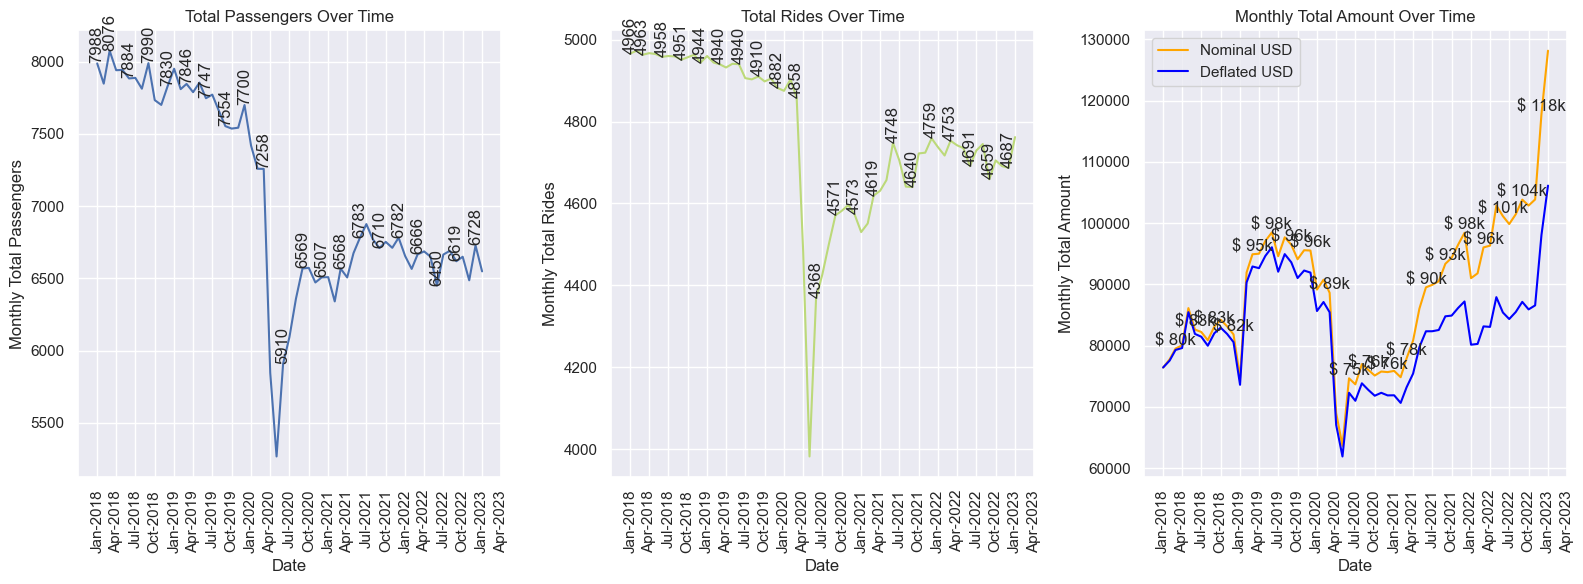

In [110]:


# Group by the formatted_pickup_date and sum the passenger_count
monthly_passenger_count = df_ny.groupby('month_of_trip')[['passenger_count','ride_count']].sum().reset_index()
monthly_passenger_count['month_of_trip'] = pd.to_datetime(monthly_passenger_count['month_of_trip'], format='%b-%y')
monthly_passenger_count.sort_values(by='month_of_trip', inplace=True)

# Group by the formatted_pickup_date and sum the total_amount
monthly_amount = df_ny.groupby('month_of_trip')[['total_amount','total_amount_ADJ']].sum().reset_index()
monthly_amount['month_of_trip'] = pd.to_datetime(monthly_amount['month_of_trip'], format='%b-%y')
monthly_amount.sort_values(by='month_of_trip', inplace=True)


# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Plot the passenger count data in the first subplot
axs[0].plot(monthly_passenger_count['month_of_trip'], monthly_passenger_count['passenger_count'])

axs[0].set_xlabel('Date')
axs[0].set_ylabel('Monthly Total Passengers')
axs[0].set_title('Total Passengers Over Time')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[0].tick_params(axis='x', rotation=90)


# Annotate data points with number labels at 3-month intervals and the first month
for x, y in zip(monthly_passenger_count['month_of_trip'], monthly_passenger_count['passenger_count']):
    if x.month % 3 == 0 or (x.month == 1 and x.year == 2018):
        axs[0].text(x, y, f'{int(y)}', ha='center', va='bottom', rotation=90)

# Plot the total amount data in the second subplot
axs[2].plot(monthly_amount['month_of_trip'], monthly_amount['total_amount'], label='Nominal USD', color='orange')
axs[2].plot(monthly_amount['month_of_trip'], monthly_amount['total_amount_ADJ'], label='Deflated USD', color='blue')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Monthly Total Amount')
axs[2].set_title('Monthly Total Amount Over Time')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[2].tick_params(axis='x', rotation=90)

# Annotate data points with number labels at 3-month intervals
for x, y in zip(monthly_amount['month_of_trip'], monthly_amount['total_amount']):
    if x.month % 3 == 0:
        axs[2].text(x, y, f'$ {y/1000:.0f}k', ha='center', va='bottom')

# Plot the passenger count data in the first subplot
axs[1].plot(monthly_passenger_count['month_of_trip'], monthly_passenger_count['ride_count'],  color='#BCD979')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Monthly Total Rides')
axs[1].set_title('Total Rides Over Time')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[1].tick_params(axis='x', rotation=90)


# Annotate data points with number labels at 3-month intervals and the first month
for x, y in zip(monthly_passenger_count['month_of_trip'], monthly_passenger_count['ride_count']):
    if x.month % 3 == 0 or (x.month == 1 and x.year == 2018):
        axs[1].text(x, y, f'{int(y)}', ha='center', va='bottom',rotation=90)

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()


The passenger count data demonstrates a consistent and substantial decline in ridership, with an estimated -15% decrease from early 2018 to 2023. Notably, the dataset highlights a significant drop in passenger numbers during the COVID-19 pandemic, underscoring the pandemic's profound impact on transportation, resulting in the lowest ridership levels. The amount payed nontheless, shows a steap increase. Which generates more questions regarding how is this increase possible. Specially for the last 2 months.

Intuitively, we can proceed to examine the time of ridership and the distance driven. Has the distance increased over time, or has the amount of time spent in the taxi increased over time? Are there more traffic congestion issues? Are people traveling longer distances?

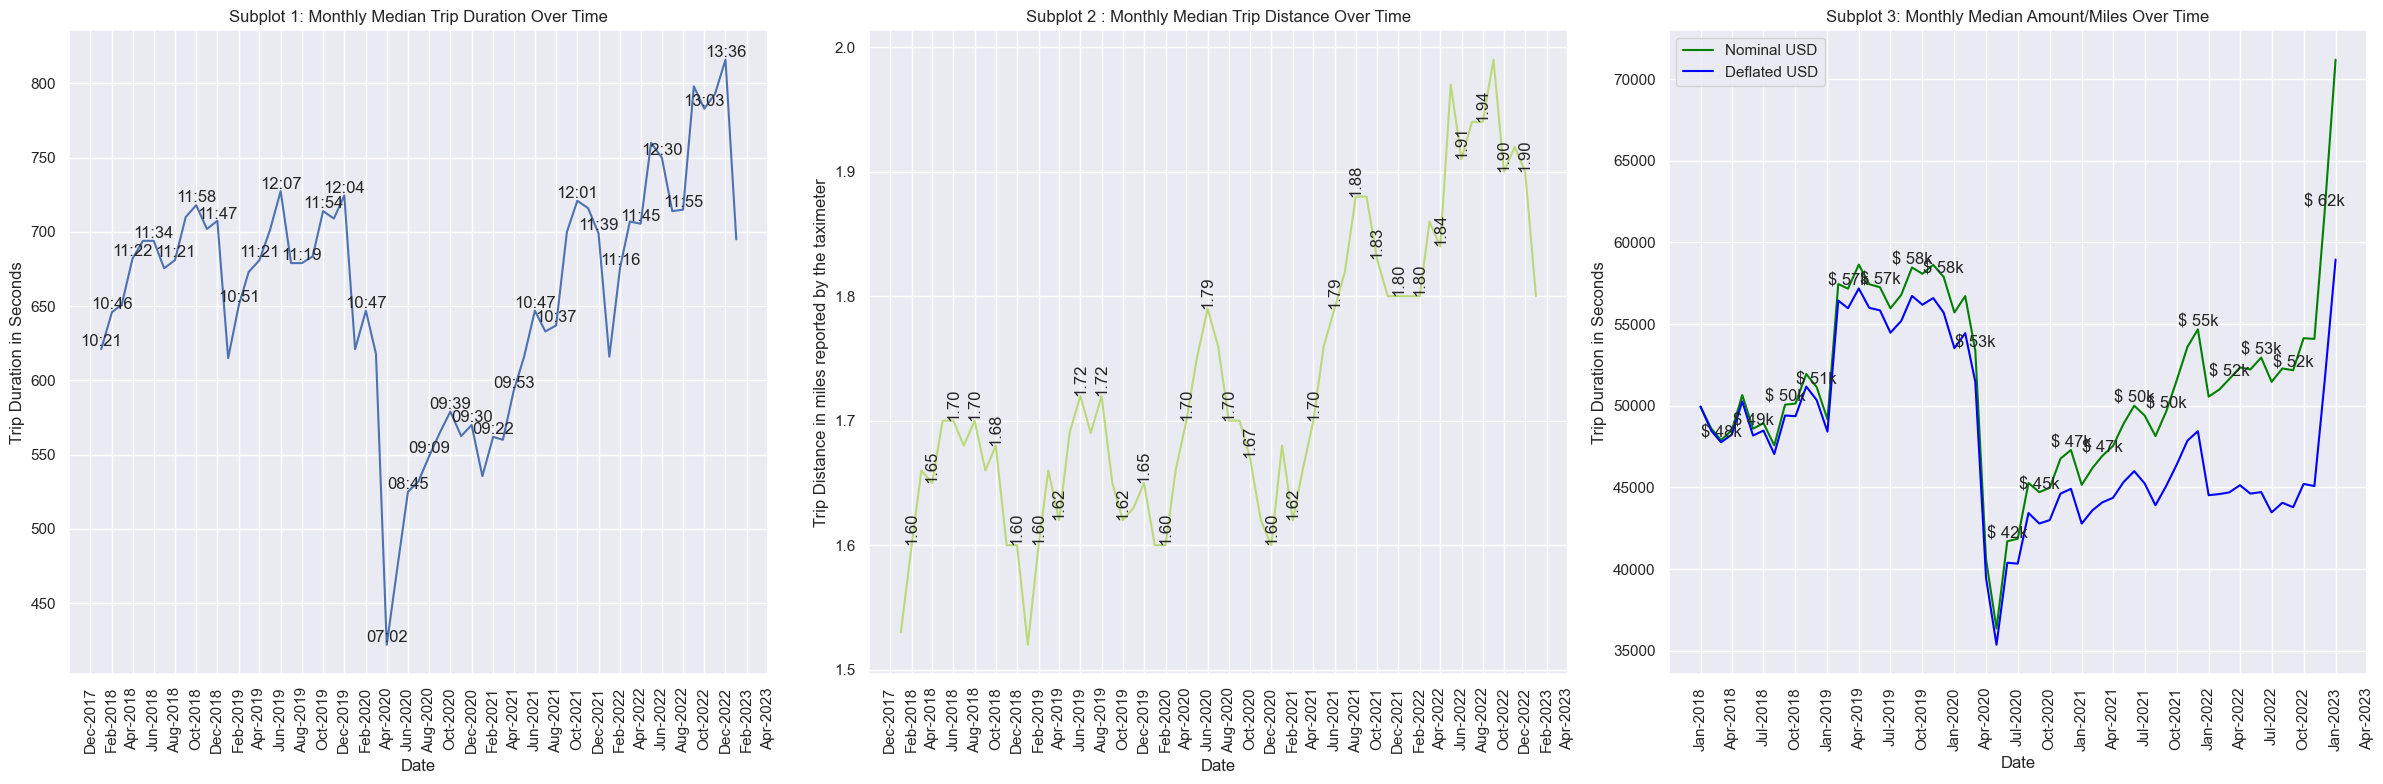

In [111]:
avg_monthly_trip_duration = df_ny.groupby('month_of_trip')['trip_duration_seconds'].median().reset_index()
avg_monthly_trip_duration['month_of_trip'] = pd.to_datetime(avg_monthly_trip_duration['month_of_trip'], format='%b-%y')
avg_monthly_trip_duration.sort_values(by='month_of_trip', inplace=True)

avg_monthly_distance = df_ny.groupby('month_of_trip')['trip_distance'].median().reset_index()
avg_monthly_distance['month_of_trip'] = pd.to_datetime(avg_monthly_distance['month_of_trip'], format='%b-%y')
avg_monthly_distance.sort_values(by='month_of_trip', inplace=True)

combined = pd.merge(monthly_amount,avg_monthly_distance, on='month_of_trip', suffixes=('_total_amount', '_trip_distance')) 
combined['amount_per_mile'] = combined['total_amount']/combined['trip_distance']
combined['amount_CDV_per_mile'] = combined['total_amount_ADJ']/combined['trip_distance']

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[1].plot(avg_monthly_distance['month_of_trip'], avg_monthly_distance['trip_distance'], color='#BCD979')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Trip Distance in miles reported by the taximeter')
axs[1].set_title('Subplot 2 : Monthly Median Trip Distance Over Time')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[1].tick_params(axis='x', rotation=90)

# Annotate data points with number labels at 3-month intervals
for x, y in zip(avg_monthly_distance['month_of_trip'], avg_monthly_distance['trip_distance']):
    if x.month % 2 == 0:
        axs[1].text(x, y, f'{y:.2f}', ha='center', va='bottom',rotation=90 )

axs[0].plot(avg_monthly_trip_duration['month_of_trip'], avg_monthly_trip_duration['trip_duration_seconds'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Trip Duration in Seconds')
axs[0].set_title('Subplot 1: Monthly Median Trip Duration Over Time')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[0].tick_params(axis='x', rotation=90)

# Annotate data points with labels in minutes:seconds format at 3-month intervals and the first month
for z, w in zip(avg_monthly_trip_duration['month_of_trip'], avg_monthly_trip_duration['trip_duration_seconds']):
    if z.month % 2 == 0 or (z.month == 1 and z.year == 2018):
        if isinstance(w, pd.Timedelta):  # Use isinstance to check if it's a Timedelta
            total_seconds = int(w.total_seconds())
        else:
            total_seconds = int(w)
        minutes = total_seconds // 60
        seconds = total_seconds % 60
        annotation_text = f'{minutes:02d}:{seconds:02d}'  # Format as mm:ss
        axs[0].text(z, total_seconds, annotation_text, ha='center', va='bottom')

axs[2].plot(combined['month_of_trip'], combined['amount_per_mile'],color='green', label='Nominal USD')
axs[2].plot(combined['month_of_trip'], combined['amount_CDV_per_mile'],color='blue', label='Deflated USD')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Trip Duration in Seconds')
axs[2].set_title('Subplot 3: Monthly Median Amount/Miles Over Time')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[2].tick_params(axis='x', rotation=90)

for x, y in  zip(combined['month_of_trip'], combined['amount_per_mile']):
    if x.month % 3 == 0:
        axs[2].text(x, y, f'$ {y/1000:.0f}k', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()


From 01.01.2018 untill 31.01.2023 we can see the an overall increase in the tendency for time and distance.For the time spent about 31% increase. Some 2 minutes and 10 seconds aprox. 
For the distance there is an increase in 19% aprox. A mean of 0.5 km per ride.  

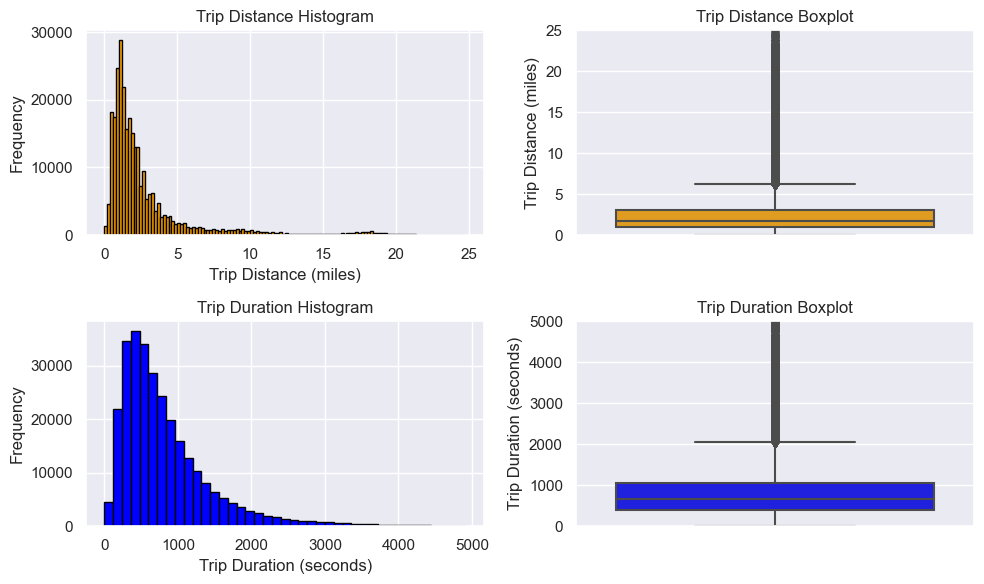

In [98]:

df_ny["trip_duration_seconds"] = pd.to_numeric(df_ny["trip_duration_seconds"], errors='coerce')

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))

# Create a histogram
ax1.hist(df_ny["trip_distance"], bins=np.arange(0, 25, 0.2), color='orange', edgecolor='black')

# Create a histogram
ax3.hist(df_ny["trip_duration_seconds"], bins=np.arange(0, 5000, 120), color='blue', edgecolor='black')

# Set labels and title for the histogram
ax1.set_xlabel('Trip Distance (miles)')
ax1.set_ylabel('Frequency')
ax1.set_title('Trip Distance Histogram')

# Create a boxplot for trip_distance
sns.boxplot(y=df_ny["trip_distance"], ax=ax2, color='orange')
ax2.set_ylim(0, 25)  # Adjust the ylim as needed

# Set labels and title for the boxplot
ax2.set_ylabel('Trip Distance (miles)')
ax2.set_title('Trip Distance Boxplot')

# Set labels and title for the histogram
ax3.set_xlabel('Trip Duration (seconds)')
ax3.set_ylabel('Frequency')
ax3.set_title('Trip Duration Histogram')

# Create a boxplot for trip_duration_seconds
sns.boxplot(y=df_ny["trip_duration_seconds"], ax=ax4, color='blue')
ax4.set_ylim(0, 5000)  # Adjust the ylim as needed

# Set labels and title for the boxplot
ax4.set_ylabel('Trip Duration (seconds)')
ax4.set_title('Trip Duration Boxplot')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


Both varaibles `trip_distance` and `trip_duration_seconds` looked somewhat skwed to the left. 

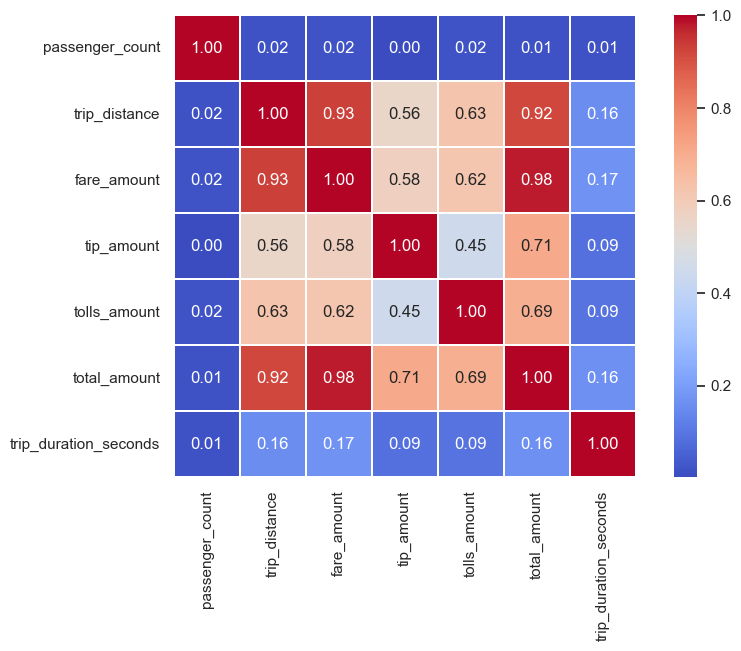

In [99]:
# Checking correlation between variables. 

numeric_df = df_ny[['passenger_count', 'trip_distance', 'fare_amount',
       'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration_seconds']]

fig = plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
sns.heatmap(numeric_df.corr(), cbar=True, annot=True, square=True,\
                 fmt='.2f',
                 annot_kws={'size': 12}, yticklabels=numeric_df.columns,\
                 xticklabels=numeric_df.columns, cmap = 'coolwarm',lw = .1)
plt.show() 

"The correlation between the numeric variables supports the visual assumptions. It appears to be a plausible explanation that the income in the taxi industry has increased due to relatively longer distances for each ride, rather than the duration. I speculate that this might be the case because longer distances can lead to lower duration due to quicker travel.



*Here, I realized that there are several trips with 0 distance and 0 duration (approximately 190), and there are also approximately 3000 trips with 0 distance and a duration of under a minute. I went back and removed them during the cleaning process because it is likely that these trips did not take place. Some of these trips also include a RateCodeID (99), which I believe signals an error, providing further justification for their removal. Additionally, there is a curious group of trips under 25 miles with durations over 20 hours. I decided to leave them as is since I don't have additional information, but it's definitely a group worth reviewing.*

Definitely, after correcting for the skewness and addressing some outlier distances and durations, the relationship between distance and duration appears to be better. Nevertheless, there is still a significant group of observations 'under the curve,' which might explain why trip duration is not as relevant as distance for the final amount paid.

But we need to account also for the inflation of the period. For this we will creat a constant USD varaible. 

C:\Users\bdupr\AppData\Local\Temp\ipykernel_21212\1056087871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['log_trip_distance'] = np.log(subset_df['trip_distance'])
C:\Users\bdupr\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bdupr\AppData\Local\Temp\ipykernel_21212\1056087871.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['log_trip_dur

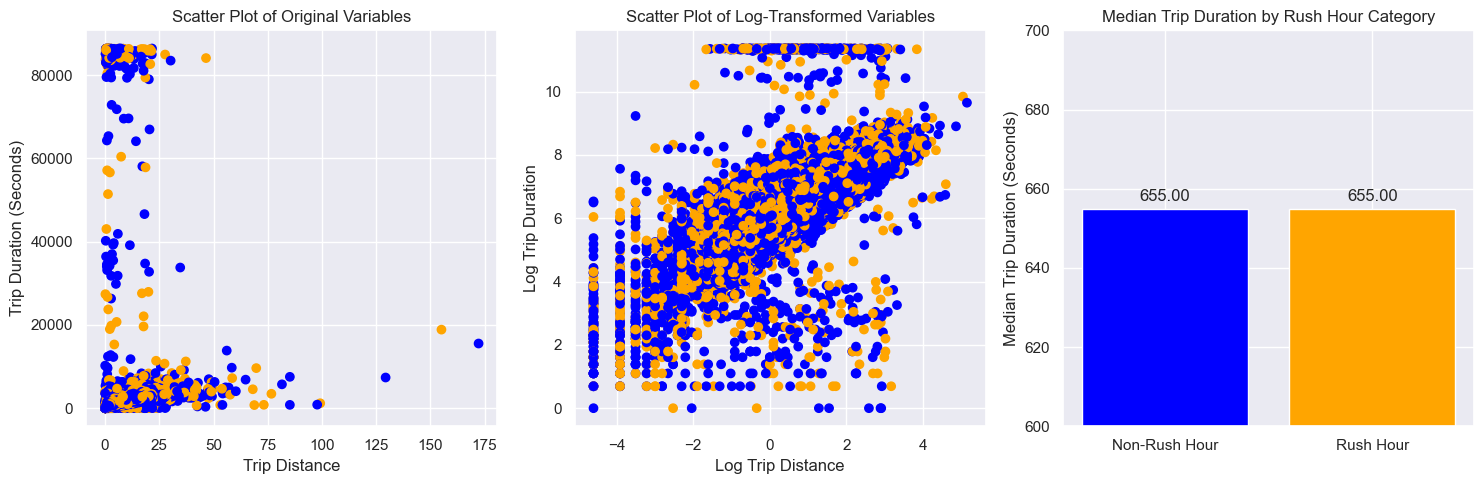

In [100]:
subset_df = df_ny[['passenger_count', 'trip_distance', 'fare_amount',
       'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration_seconds','rushhour_flag' ]]

# Log-transform 'trip_distance' and 'trip_duration'
subset_df['log_trip_distance'] = np.log(subset_df['trip_distance'])
subset_df['log_trip_duration'] = np.log(subset_df['trip_duration_seconds'])

# Create a color map based on the 'rushhour_flag' category variable
colors = np.where(subset_df['rushhour_flag'], 'orange', 'blue')

# Plot the log-transformed variables with color
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot of original variables
ax1.scatter(subset_df['trip_distance'], numeric_df['trip_duration_seconds'], c=colors)
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Trip Duration (Seconds)')
ax1.set_title('Scatter Plot of Original Variables')

# Scatter plot of log-transformed variables
ax2.scatter(subset_df['log_trip_distance'], subset_df['log_trip_duration'], c=colors)
ax2.set_xlabel('Log Trip Distance')
ax2.set_ylabel('Log Trip Duration')
ax2.set_title('Scatter Plot of Log-Transformed Variables') 

# Bar chart of average trip duration for rush hour category
average_duration = subset_df.groupby('rushhour_flag')['trip_duration_seconds'].median()
labels = ['Non-Rush Hour', 'Rush Hour']
bars = ax3.bar(labels, average_duration, color=['blue', 'orange'])
ax3.set_ylabel('Median Trip Duration (Seconds)')
ax3.set_title('Median Trip Duration by Rush Hour Category')
ax3.set_ylim(600,700)

# Add mean values as text annotations on top of the bars
for bar, mean_value in zip(bars, average_duration):
    ax3.annotate(f'{mean_value:.2f}', xy=(bar.get_x() + bar.get_width() / 2, mean_value),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()



*Here, I realized that there are several trips with 0 distance and 0 duration (approximately 190), and there are also approximately 3000 trips with 0 distance and a  0 duration. I went back and removed them during the cleaning process because it is likely that these trips did not take place. Some of these trips also include a RateCodeID (99), which I believe signals an error, providing further justification for their removal. Additionally, there is a curious group of trips under 25 miles with durations over 20 hours. I decided to leave them as is since I don't have additional information, but it's definitely a group worth reviewing.*

Definitely, after correcting for the skewness and addressing some outlier distances and durations, the relationship between distance and duration appears to be better. Nevertheless, there is still a significant group of observations 'under the curve,' which might explain why trip duration is not as relevant as distance for the final amount paid. Rush or no Rush Hour is mearly a 8 sec difference in avarage and no difference considering the median. 

## Analysis

In [101]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#encoded_df = pd.get_dummies(df_ny, columns=['PULocationID','DOLocationID','payment_type','rushhour_flag','pickup_weekday'])
#print(encoded_df.columns)


# Define the dependent variable (Y) and independent variables (X)
Y = df_ny['total_amount_ADJ']
X_1 = df_ny[['trip_distance', 'tip_amount', 'rushhour_flag']]
#X_1 = encoded_df[['trip_distance', 'tip_amount', 'rushhour_flag_0', 'rushhour_flag_1', 'pickup_weekday_0', 'pickup_weekday_1', 'pickup_weekday_2', 'pickup_weekday_3', 'pickup_weekday_4', 'pickup_weekday_5', 'pickup_weekday_6']]

# Split the data into training/testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, Y, test_size=0.2, random_state=42)

# Create a linear regression model
reg = LinearRegression()

# Fit the model to the training data
reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = reg.predict(X_test)

# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is a perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs (for individual variables, not the multi-variable case)
plt.scatter(X_test['trip_distance'], y_test, color="black", label="Actual")
plt.scatter(X_test['trip_distance'], y_pred, color="blue", linewidth=0.1, label="Predicted")

plt.xlabel('Trip Distance')
plt.ylabel('Total Amount ADJ')
plt.legend()
plt.show()




ModuleNotFoundError: No module named 'sklearn'

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'fare_amount', 'extra', 'mta_tax',
       ...
       'payment_type_5', 'rushhour_flag_False', 'rushhour_flag_True',
       'pickup_weekday_0', 'pickup_weekday_1', 'pickup_weekday_2',
       'pickup_weekday_3', 'pickup_weekday_4', 'pickup_weekday_5',
       'pickup_weekday_6'],
      dtype='object', length=535)
Coefficients: 
 [ 2.62155399  1.36948928 -0.24904232  0.24904232 -0.15026397  0.17941532
  0.2837971   0.38008594  0.25976201 -0.30387678 -0.64891961]
Mean squared error: 19.21
Coefficient of determination: 0.89


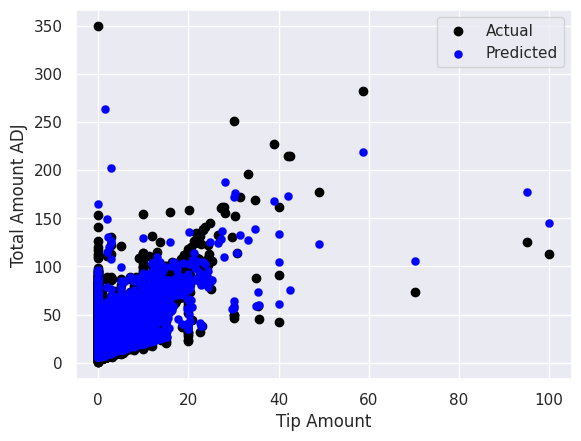

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

encoded_df = pd.get_dummies(df_ny, columns=['PULocationID', 'DOLocationID', 'payment_type', 'rushhour_flag', 'pickup_weekday'])
print(encoded_df.columns)

# Define the dependent variable (Y)
Y = df_ny['total_amount_ADJ']

# Find the correct column names that resulted from one-hot encoding 'rushhour_flag' and 'pickup_weekday'
rushhour_columns = [col for col in encoded_df.columns if col.startswith('rushhour_flag')]
pickup_weekday_columns = [col for col in encoded_df.columns if col.startswith('pickup_weekday')]

# Create X_1 by selecting the relevant columns
X_1 = encoded_df[['trip_distance', 'tip_amount'] + rushhour_columns + pickup_weekday_columns]

# Split the data into training/testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, Y, test_size=0.2, random_state=42)

# Create a linear regression model
reg = LinearRegression()

# Fit the model to the training data
reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = reg.predict(X_test)

# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is a perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs (for individual variables, not the multi-variable case)
plt.scatter(X_test['tip_amount'], y_test, color="black", label="Actual")
plt.scatter(X_test['tip_amount'], y_pred, color="blue", linewidth=0.1, label="Predicted")

plt.xlabel('Tip Amount')
plt.ylabel('Total Amount ADJ')
plt.legend()
plt.show()


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


an_ny = df_ny[["RatecodeID", "VendorID", "store_and_fwd_flag",
              'passenger_count', 'trip_distance', 'extra','fare_amount','mta_tax','airport_fee','congestion_surcharge',
                     'improvement_surcharge','tip_amount', 'tolls_amount',  'trip_duration_seconds',
                       'total_amount_ADJ', "payment_type", "rushhour_flag", "pickup_weekday"]] # droppping date format variables
X = an_ny.drop(columns=['total_amount_ADJ'])  # Exclude 'total_amount_ADJ' column
y = an_ny['total_amount_ADJ']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

categorical_columns = ["RatecodeID", "VendorID", "store_and_fwd_flag", "payment_type", "rushhour_flag", "pickup_weekday"]
numerical_columns = ['passenger_count', 'trip_distance', 'extra','fare_amount','mta_tax','airport_fee','congestion_surcharge',
                     'improvement_surcharge','tip_amount', 'tolls_amount', 'trip_duration_seconds']

# Specify categories for OneHotEncoder
#categories = [X[c].unique() for c in categorical_columns]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
) # avoid to prepend the preprocessor names


from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RatecodeID', 'VendorID',
                                                   'store_and_fwd_flag',
                                                   'payment_type',
                                                   'rushhour_flag',
                                                   'pickup_weekday'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

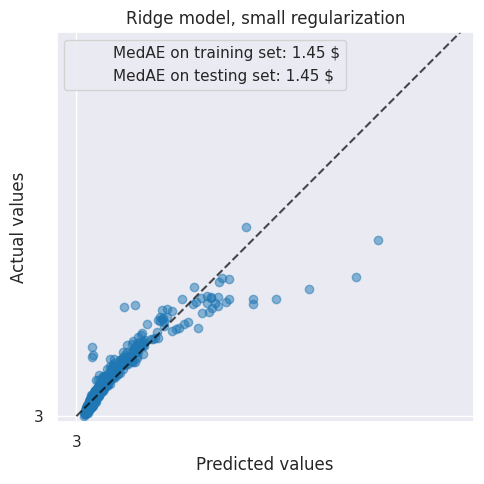

In [ ]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $",
    "MedAE on testing set": f"{mae_test:.2f} $",
}
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
# Set the limits for both x-axis and y-axis
ax.set_xlim([0, 200]) # leaving 4 outlayier 
ax.set_ylim([0, 200])    
ax.legend(loc="upper left")
plt.tight_layout()

In [ ]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs



,Coefficients
RatecodeID_1.0,3.389335e-01
RatecodeID_2.0,1.490183e-01
RatecodeID_3.0,8.188039e-02
RatecodeID_4.0,-9.143993e-02
RatecodeID_5.0,-8.022889e-02
VendorID_1,-8.817146e-02
VendorID_2,-7.467068e-02
VendorID_4,-7.262949e-02
store_and_fwd_flag_1,-7.171233e-03
payment_type_1,4.642943e-02


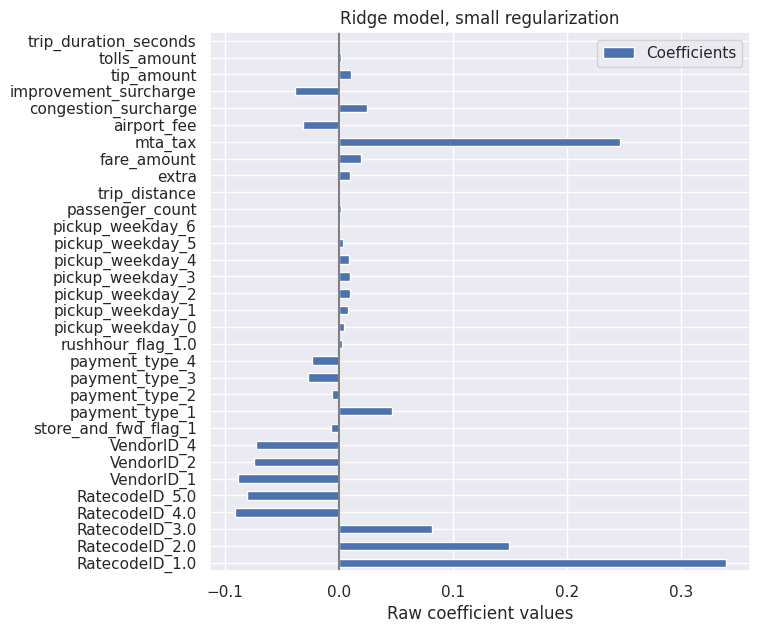

In [ ]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

### References and Resources:

Used Chat GPT for reference:
https://chat.openai.com/ 

Following repository in github:
https://github.com/norberte/DS_professional_development/blob/master/DS%20interviews/NYC%20Yellow%20Taxi.ipynb

Time series CPI from :
https://fred.stlouisfed.org/series/CPIAUCSL#0

Library Instructions:
https://seaborn.pydata.org/generated/seaborn.pairplot.html

Inflation Adjusted:
https://timeseriesreasoning.com/contents/inflation-adjustment/

Machine Learning Bit:
https://scikit-learn.org/stable/modules/linear_model.html